In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from astropy.io import fits
from astropy.wcs import WCS
from m33_utils import open_and_select
from matplotlib.lines import Line2D

np.seterr(all='ignore')

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

In [86]:
def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None, norm_args={},
                 offset=0.0175, width=0.0225, label='Density'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(**norm_args, vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

In [3]:
ds = open_and_select('../legacy_phot/M33_full_matched.hdf5')

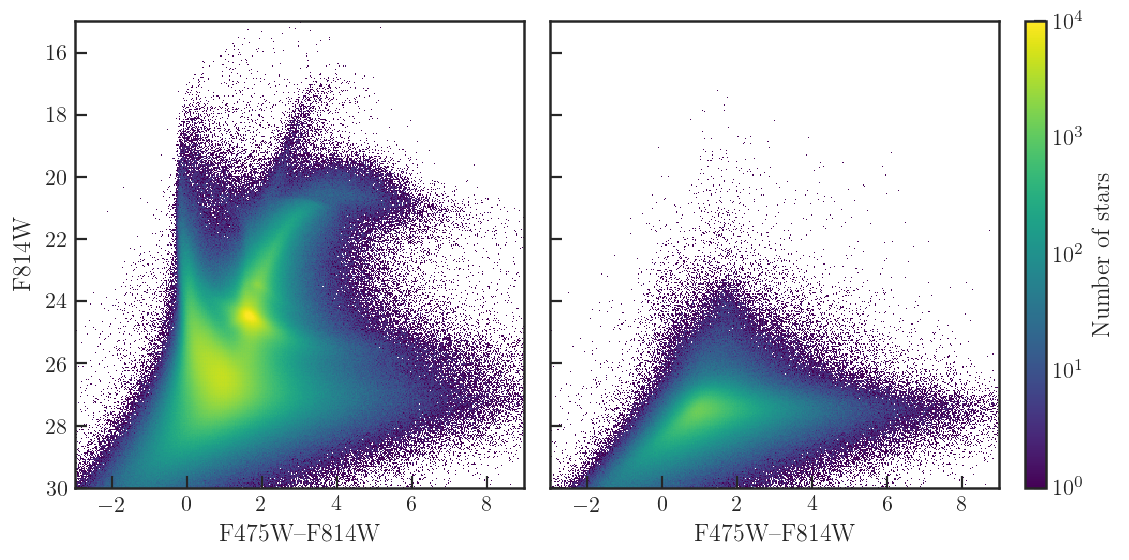

In [4]:
# W14 Fig 7

colormap, vmin, vmax = 'viridis', 1, 1e4
cmap = getattr(mpl.cm, colormap)
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

opt_lim = [[-3, 9], [30, 15]]

fig = plt.figure(figsize=(7.2, 4))
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=opt_lim,
        f='log10', colorbar=False, colormap=colormap,
        vmin=np.log10(vmin), vmax=np.log10(vmax), interpolation='None', shape=420,
        selection=[None, '~OPT_ST'], visual=dict(column='selection'),
        xlabel='F475W--F814W', ylabel='F814W')
ax0, ax1 = fig.get_axes()
ax1.set_ylabel(None)
ax1.set_yticklabels([])
fig.tight_layout()

pos = ax1.get_position()
cax = fig.add_axes([pos.x1+0.025, pos.y0, 0.02, pos.height])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Number of stars')

fig.savefig('survey_paper_figures/F475W_F814W_full_cut_CMDs.pdf', dpi=420, bbox_inches='tight')

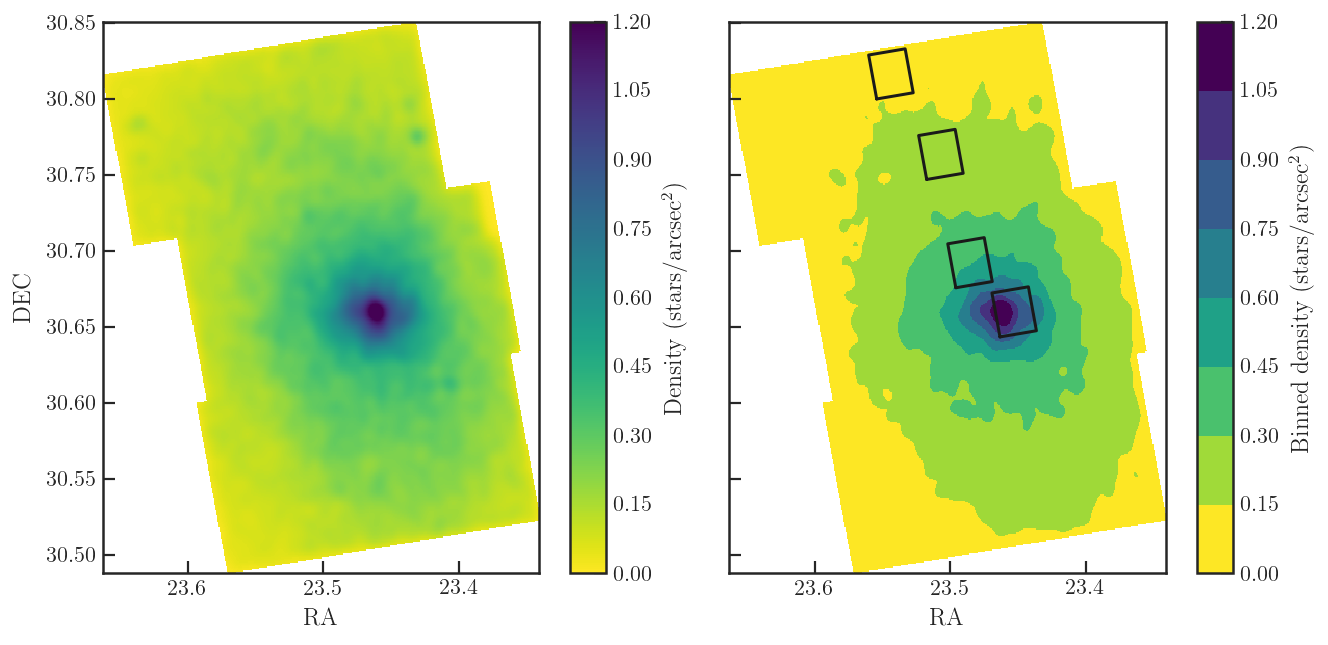

In [9]:
# W14 Fig 10
cmap, ncolors = 'viridis_r', 8
ds.plot('RA','DEC', what=['mean(DENSITY)', 'mean(DENSITY)'], limits='minmax', shape=420, 
        colormap=[cmap, plt.get_cmap(cmap, ncolors)], vmin=0, vmax=1.2,
        colorbar=False, figsize=(8.4, 5.6), interpolation='None')
fig = plt.gcf()
fig.tight_layout(w_pad=4)
ax, ax2 = fig.get_axes()#[0]
ax2.set_yticklabels([])
ax2.set_ylabel('')
#ax = ax2

cbar = add_colorbar(fig, ax, cmap=cmap, vmin=0, vmax=1.2, #n_colors=ncolors,
                    width=0.03, offset=0.025, label='Density (stars/arcsec$^2$)')
cbar.set_ticks(np.round(np.arange(0, 1.3, 0.15), 2))


cbar = add_colorbar(fig, ax2, cmap=cmap, vmin=0, vmax=1.2, n_colors=ncolors,
                    width=0.03, offset=0.025, label='Binned density (stars/arcsec$^2$)')
cbar.set_ticks(np.round(np.arange(0, 1.3, 0.15), 2))

ax.invert_xaxis()
ax2.invert_xaxis()

fields = ['M33_B01_NN', 'M33_B01_SS', 'M33_B02_NN', 'M33_B02_SS']

dx = dy = 0
for field in fields:
    n = 3 if field.endswith('SS') else 2
    with open(f'../{field}/{field}_{n}.param') as f:
        for line in f:
            if line.startswith('photsec'):
                xmin, xmax = [int(l) for l in line.split()[4::2]]
    ymin, ymax = vaex.open(f'../artstars/{field}_fake_final.hdf5').minmax('Y_IN')
    w = WCS(fits.Header.fromtextfile(f'../{field}/{field}_F475W_drc_wcs.txt'))
    ra, dec = w.all_pix2world(np.c_[[xmin+dx, xmax+dx, xmax+dx, xmin+dx, xmin+dx],
                                    [ymin+dy, ymin+dy, ymax+dy, ymax+dy, ymin+dy]], 0.5).T
    ax2.plot(ra, dec, 'k')

fig.savefig('survey_paper_figures/density_map.pdf', dpi=300, bbox_inches='tight')

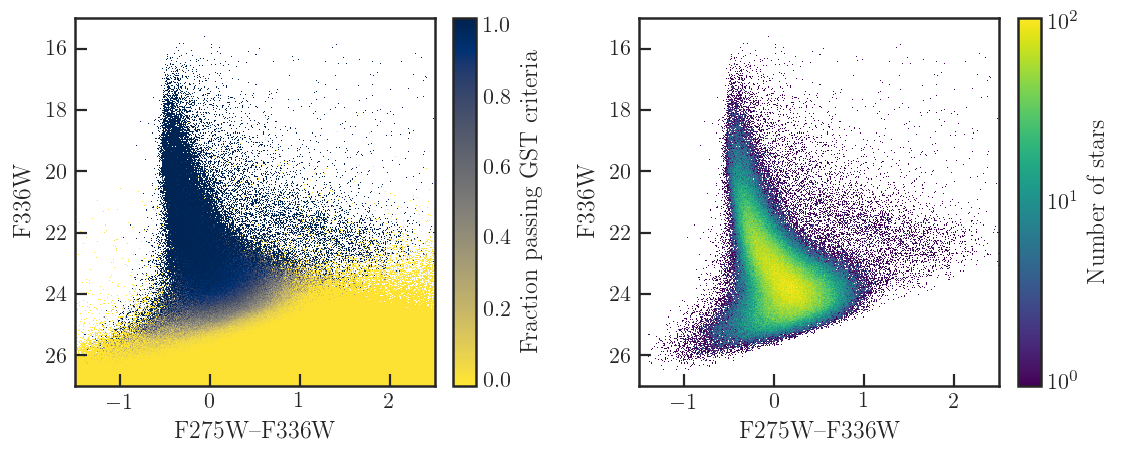

In [6]:
# W14 Fig 9
ds.plot('F275W_VEGA-F336W_VEGA', 'F336W_VEGA', figsize=(7.2, 4), 
        limits=[[-1.5, 2.5], [27, 15]], shape=360, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.95)], vmax=[1.02, np.log10(1.05e2)],
        what=['mean(F275W_GST_FLAG*F336W_GST_FLAG)',
              'sum(F275W_GST_FLAG*F336W_GST_FLAG)'],
        xlabel='F275W--F336W', ylabel='F336W')

fig = plt.gcf()
fig.tight_layout(w_pad=6)

axes = fig.get_axes()

add_colorbar(fig, axes[0], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[1], cmap='viridis', vmin=0.95, vmax=1.05e2,
             norm='LogNorm', label='Number of stars')

fig.savefig('survey_paper_figures/F275W_F336W_CMDs.pdf', dpi=420, bbox_inches='tight')


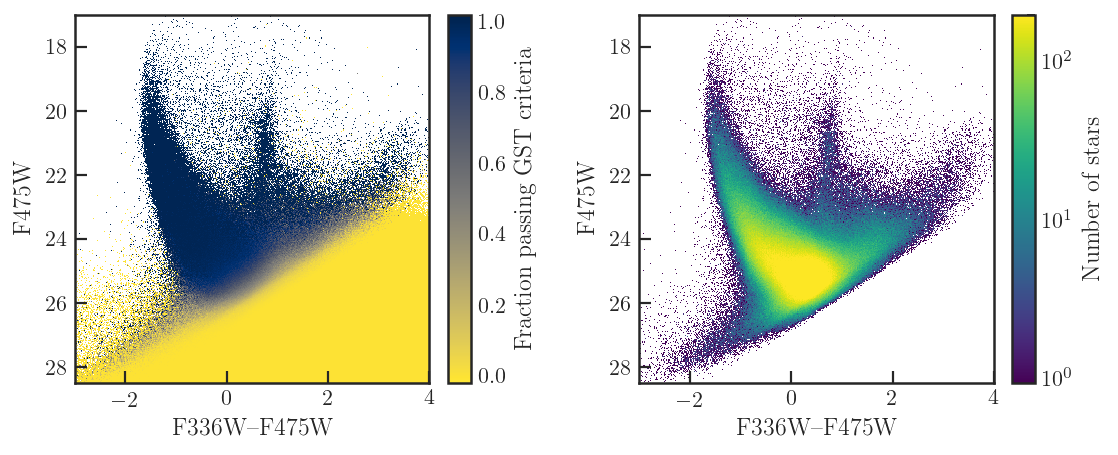

In [7]:
# W14 Fig 11-12
ds.plot('F336W_VEGA-F475W_VEGA', 'F475W_VEGA', figsize=(7.2, 4), 
        limits=[[-3, 4], [28.5, 17]], shape=360, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.95)], vmax=[1.02, np.log10(2e2)],
        what=['mean(F336W_GST_FLAG*F475W_GST_FLAG)',
              'sum(F336W_GST_FLAG*F475W_GST_FLAG)'],
        xlabel='F336W--F475W', ylabel='F475W')

fig = plt.gcf()
fig.tight_layout(w_pad=6)

axes = fig.get_axes()

add_colorbar(fig, axes[0], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[1], cmap='viridis', vmin=0.95, vmax=2e2,
             norm='LogNorm', label='Number of stars')

fig.savefig('survey_paper_figures/F336W_F475W_CMDs.pdf', dpi=420, bbox_inches='tight')


In [8]:
density_tuples_lo = [(0, 0.15), (0.15, 0.3), (0.3, 0.6)]
density_tuples_hi = [(0.6, 0.9), (0.9, 1.2), (1.2, 100)]

In [9]:
def make_cmd_fig(ds, f_blue, f_red, limits, density_tuples, fig_height=5.6, shape=420, 
                 f_frac=None, f_dens='log10', cmap_frac='cividis_r', cmap_dens='viridis',
                 vmin_frac=-0.02, vmax_frac=1.02, vmin_dens=0.9, vmax_dens=1.1e3,
                 textpos = 'top right'):
    selections = [f'(DENSITY >= {d0}) & (DENSITY < {d1})' for d0, d1 in density_tuples]
    n = len(selections)
    fig_width = n*2.5 + 0.5
    
    ds.plot(f'{f_blue}_VEGA-{f_red}_VEGA', f'{f_red}_VEGA',
            figsize=(fig_width, fig_height), limits=limits, shape=shape, colorbar=False,
            f=[f_frac, f_dens], colormap=[cmap_frac, cmap_dens],
            vmin=[vmin_frac, np.log10(vmin_dens)], vmax=[vmax_frac, np.log10(vmax_dens)],
            what=[f'mean({f_blue}_GST_FLAG*{f_red}_GST_FLAG)',
                  f'sum({f_blue}_GST_FLAG*{f_red}_GST_FLAG)'],
            selection=selections,
            visual=dict(row='what', column='selection'),
            xlabel=f'{f_blue}--{f_red}', ylabel=f_red)
    
    fig = plt.gcf()
    axes = fig.get_axes()
    for ax in axes[1:n] + axes[(n+1):]:
        ax.set_ylabel(None)
        ax.set_yticklabels([])
    for ax in axes[:-n]:
        ax.set_xlabel(None)
        ax.set_xticklabels([])
    
    va, ha = textpos.split()
    x = 0.95 if (va == 'top') else 0.05 if (va == 'bottom') else None
    y = 0.95 if (ha == 'right') else 0.05 if (ha == 'left') else None
    for i, (d0, d1) in enumerate(density_tuples):
        for ax in axes[0+i:(n+1)+i:n]:
            dstr = f'{d0} -- {d1}' if (d1 <= 1.2) else f'{d0}+'
            ax.text(x, y, dstr, ha=ha, va=va, transform=ax.transAxes)
    fig.tight_layout(w_pad=0, h_pad=1)

    add_colorbar(fig, axes[-(n+1)], cmap=cmap_frac, vmin=vmin_frac, vmax=vmax_frac,
                 norm='Normalize', label='Fraction passing GST criteria')
    add_colorbar(fig, axes[-1], cmap=cmap_dens, vmin=vmin_dens, vmax=vmax_dens,
                 norm='LogNorm', label='Number of stars')
    return fig


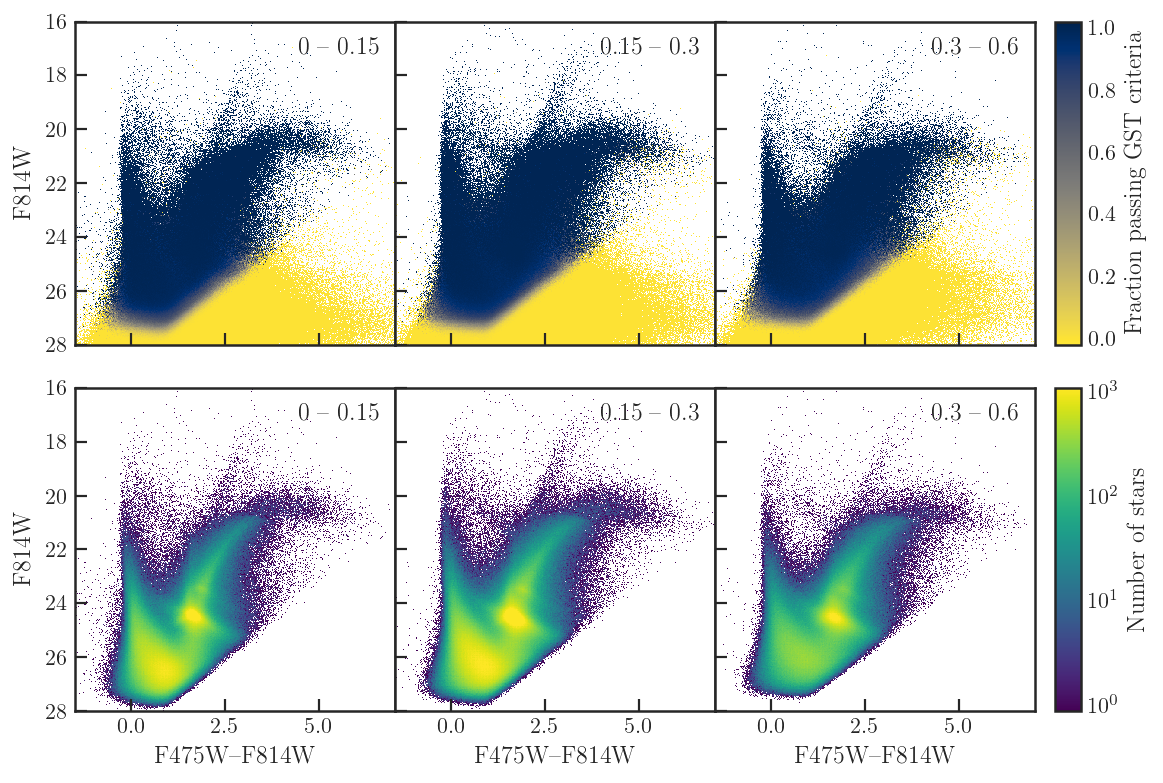

In [10]:
# W14 Fig 13-14
fig = make_cmd_fig(ds, 'F475W', 'F814W', [[-1.5, 7], [28, 16]], density_tuples_lo)
fig.savefig('survey_paper_figures/F475W_F814W_CMDs_low_density.pdf', dpi=420, bbox_inches='tight')


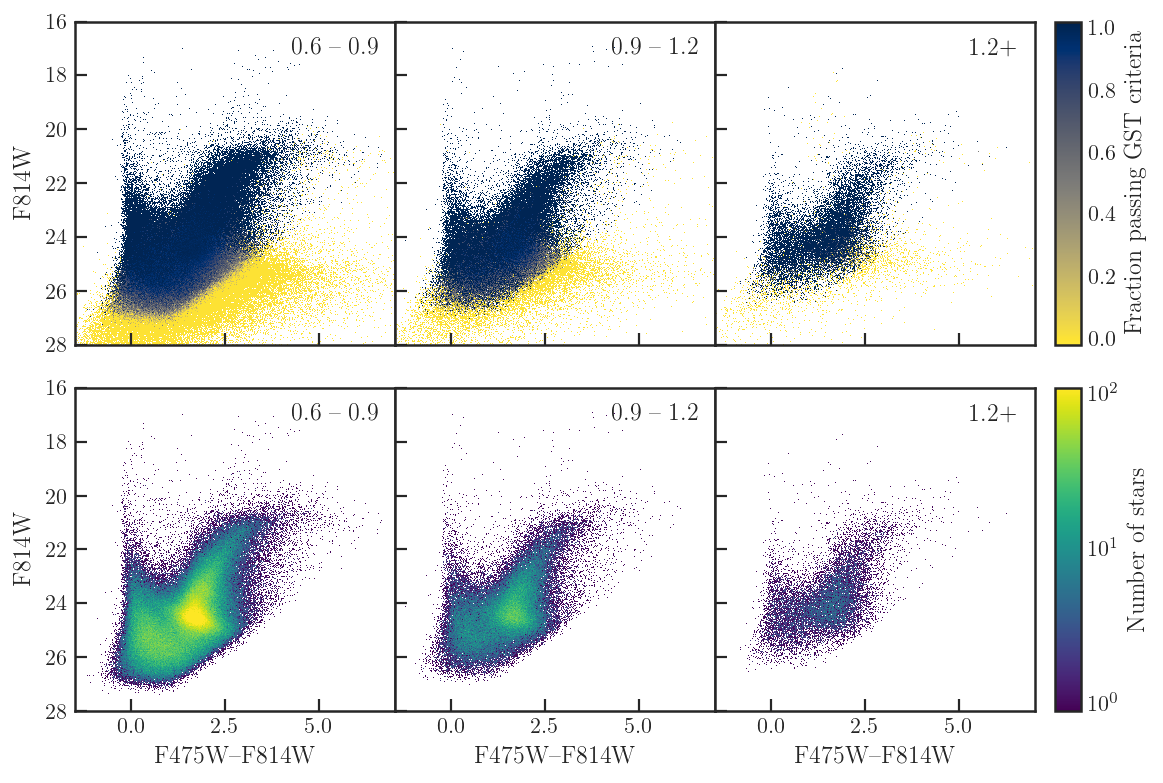

In [11]:
fig = make_cmd_fig(ds, 'F475W', 'F814W', [[-1.5, 7], [28, 16]], density_tuples_hi,
                   vmax_dens=1.1e2)
fig.savefig('survey_paper_figures/F475W_F814W_CMDs_high_density.pdf', dpi=420, bbox_inches='tight')


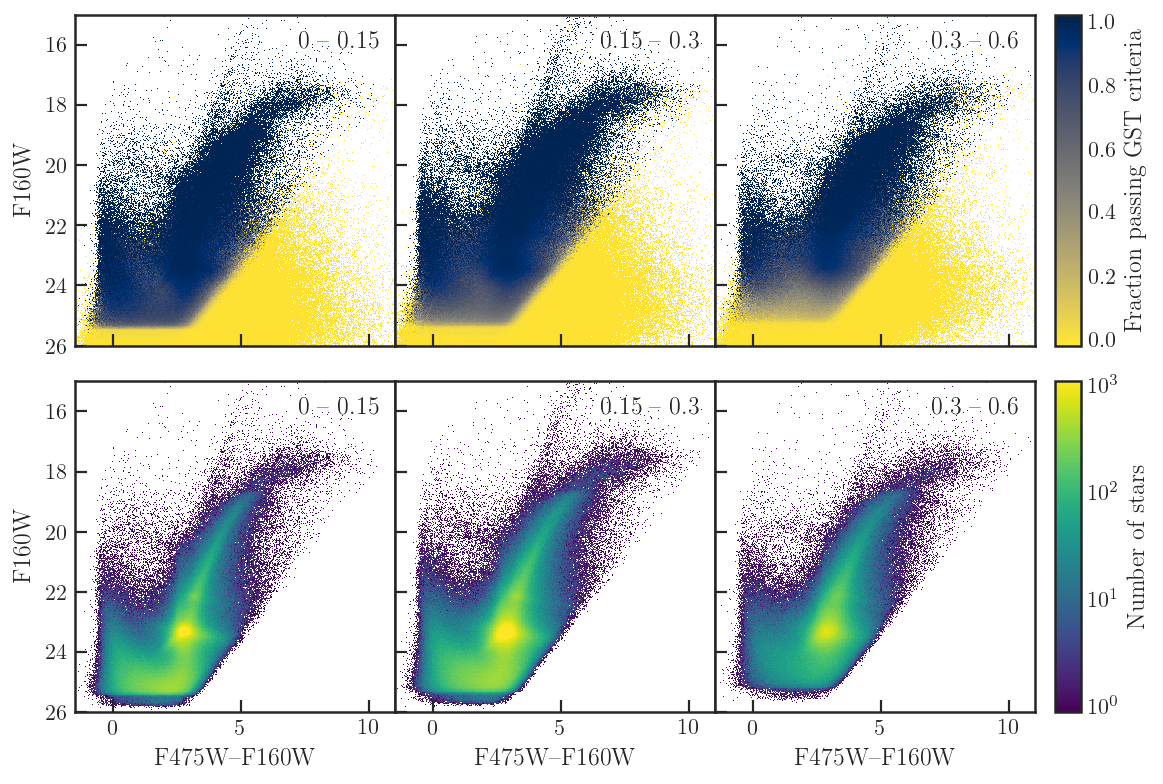

In [12]:
# W14 Fig 15-16
fig = make_cmd_fig(ds, 'F475W', 'F160W', [[-1.5, 11], [26, 15]], density_tuples_lo)
fig.savefig('survey_paper_figures/F475W_F160W_CMDs_low_density.pdf', dpi=420, bbox_inches='tight')


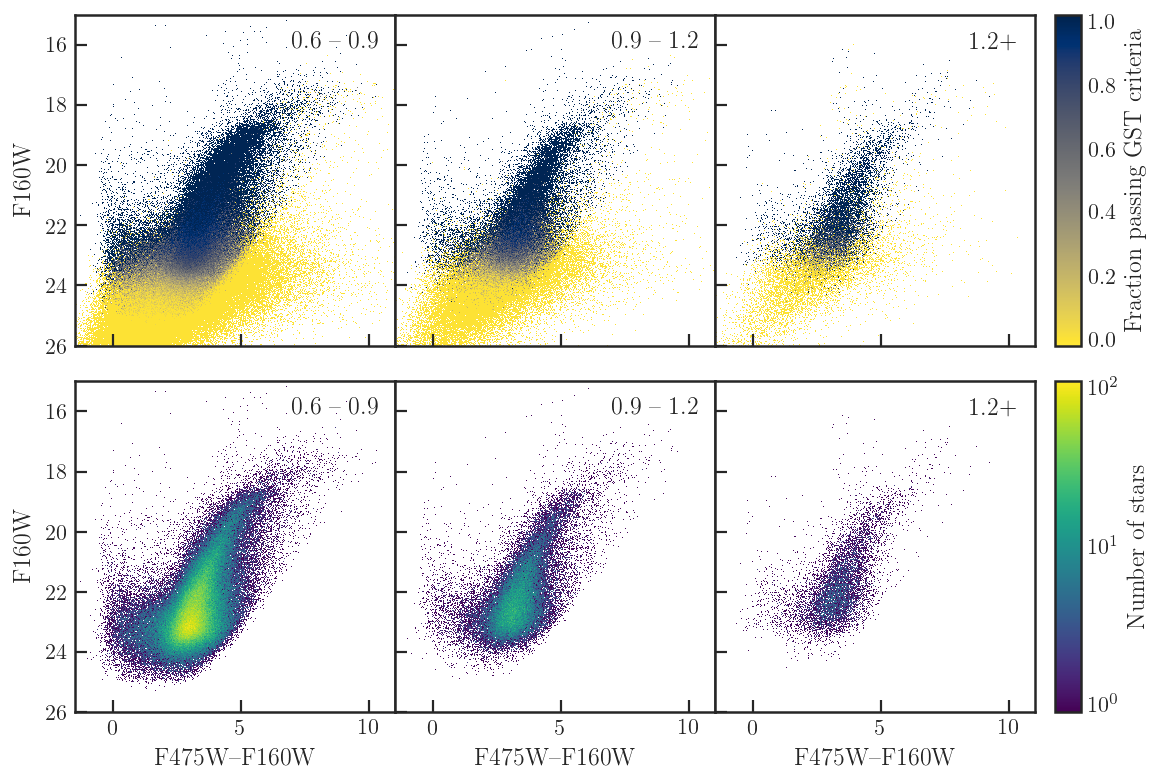

In [13]:
fig = make_cmd_fig(ds, 'F475W', 'F160W', [[-1.5, 11], [26, 15]], density_tuples_hi, vmax_dens=1.1e2)
fig.savefig('survey_paper_figures/F475W_F160W_CMDs_high_density.pdf', dpi=420, bbox_inches='tight')


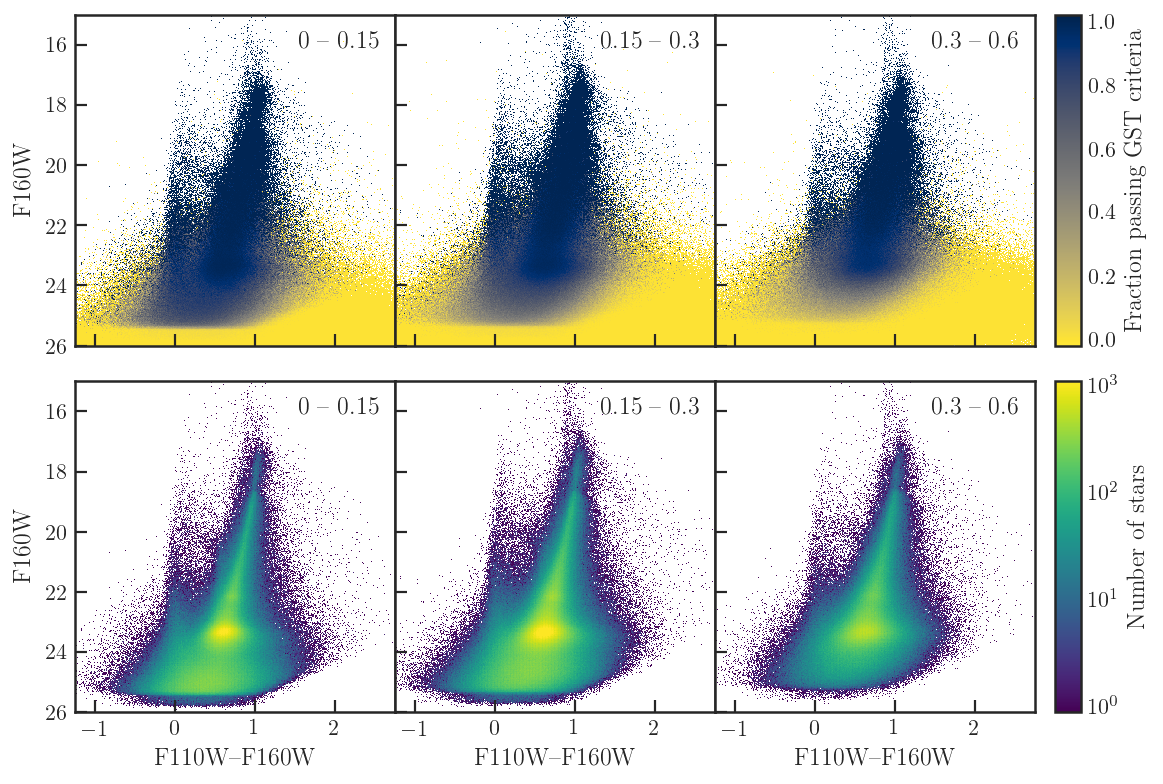

In [14]:
# W14 Fig 17-18
fig = make_cmd_fig(ds, 'F110W', 'F160W', [[-1.25, 2.75], [26, 15]], density_tuples_lo)
fig.savefig('survey_paper_figures/F110W_F160W_CMDs_low_density.pdf', dpi=420, bbox_inches='tight')


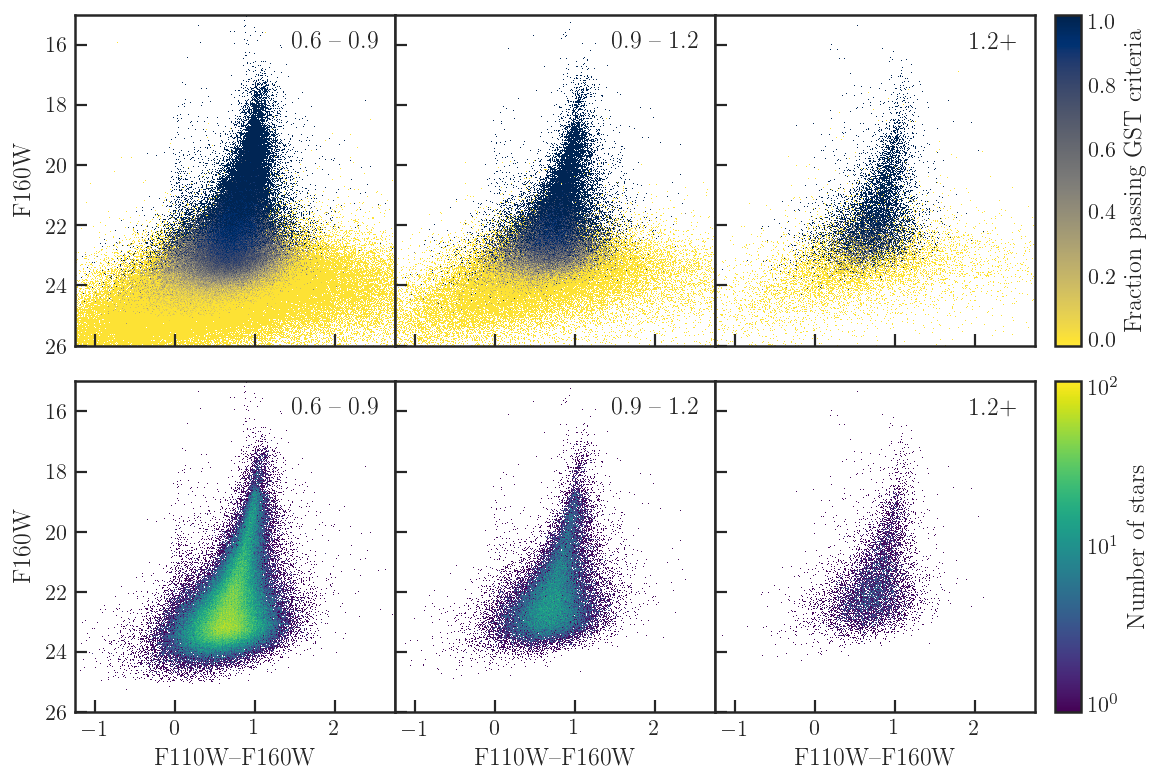

In [15]:
fig = make_cmd_fig(ds, 'F110W', 'F160W', [[-1.25, 2.75], [26, 15]], density_tuples_hi, vmax_dens=1.1e2)
fig.savefig('survey_paper_figures/F110W_F160W_CMDs_high_density.pdf', dpi=420, bbox_inches='tight')


In [16]:
n_det = ds.evaluate('+'.join(ds.get_column_names(regex='F.*?W_GST_FLAG')))
if 'n_detected' in ds.get_column_names():
    ds.drop('n_detected', inplace=True)
ds.add_column('n_detected', n_det)

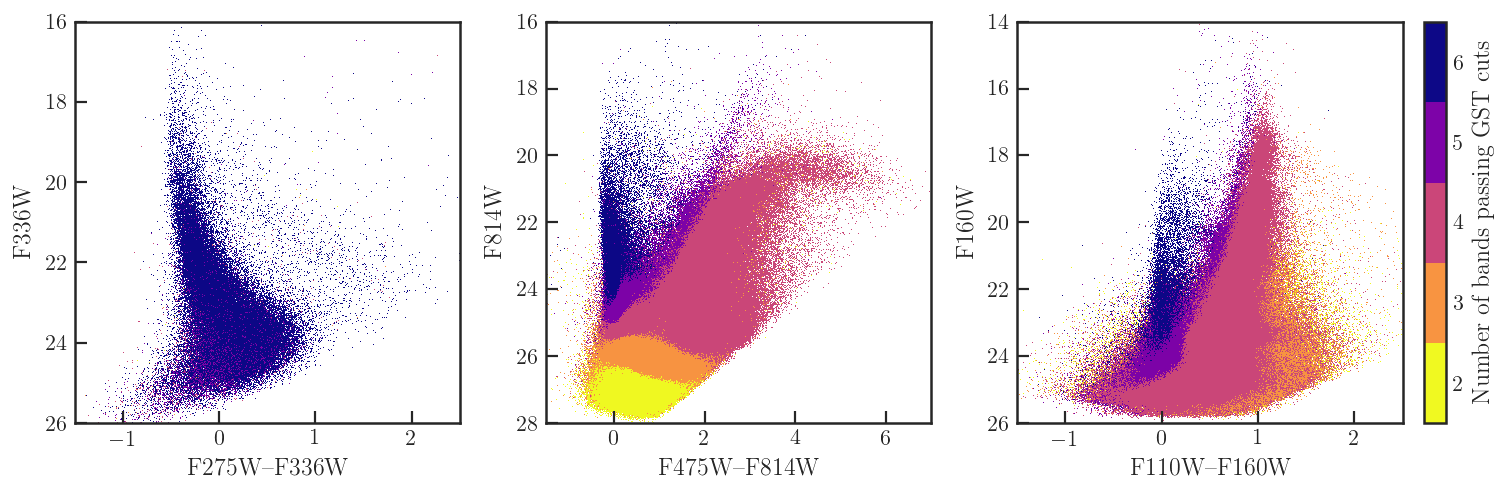

In [17]:
# W14 Fig 8

colormap_frac, vmin_frac, vmax_frac = plt.cm.get_cmap('plasma_r', 5), 1.5, 6.5
cmap_frac = colormap_frac #getattr(mpl.cm, colormap_frac)
norm_frac = mpl.colors.Normalize(vmin_frac, vmax_frac)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 3.6))

plt.sca(ax0)
ds.plot('F275W_VEGA-F336W_VEGA', 'F336W_VEGA', limits=[[-1.5, 2.5], [26, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F275W--F336W', ylabel='F336W', selection=['UV_GST & (DENSITY < 0.15)'])

plt.sca(ax1)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=[[-1.5, 7], [28, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F475W--F814W', ylabel='F814W', selection=['OPT_GST & (DENSITY < 0.15)'])

plt.sca(ax2)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=[[-1.5, 2.5], [26, 14]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F110W--F160W', ylabel='F160W', selection=['IR_GST & (DENSITY < 0.15)'])

fig.tight_layout()

cbar = add_colorbar(fig, ax2, cmap='plasma_r', vmin=1.5, vmax=6.5,
                    norm='Normalize', n_colors=5,
                    offset=0.015, width=0.015, label='Number of bands passing GST cuts')

fig.savefig('survey_paper_figures/nbands_cmds.pdf', dpi=420, bbox_inches='tight')


<string>:1: RuntimeWarning: invalid value encountered in less


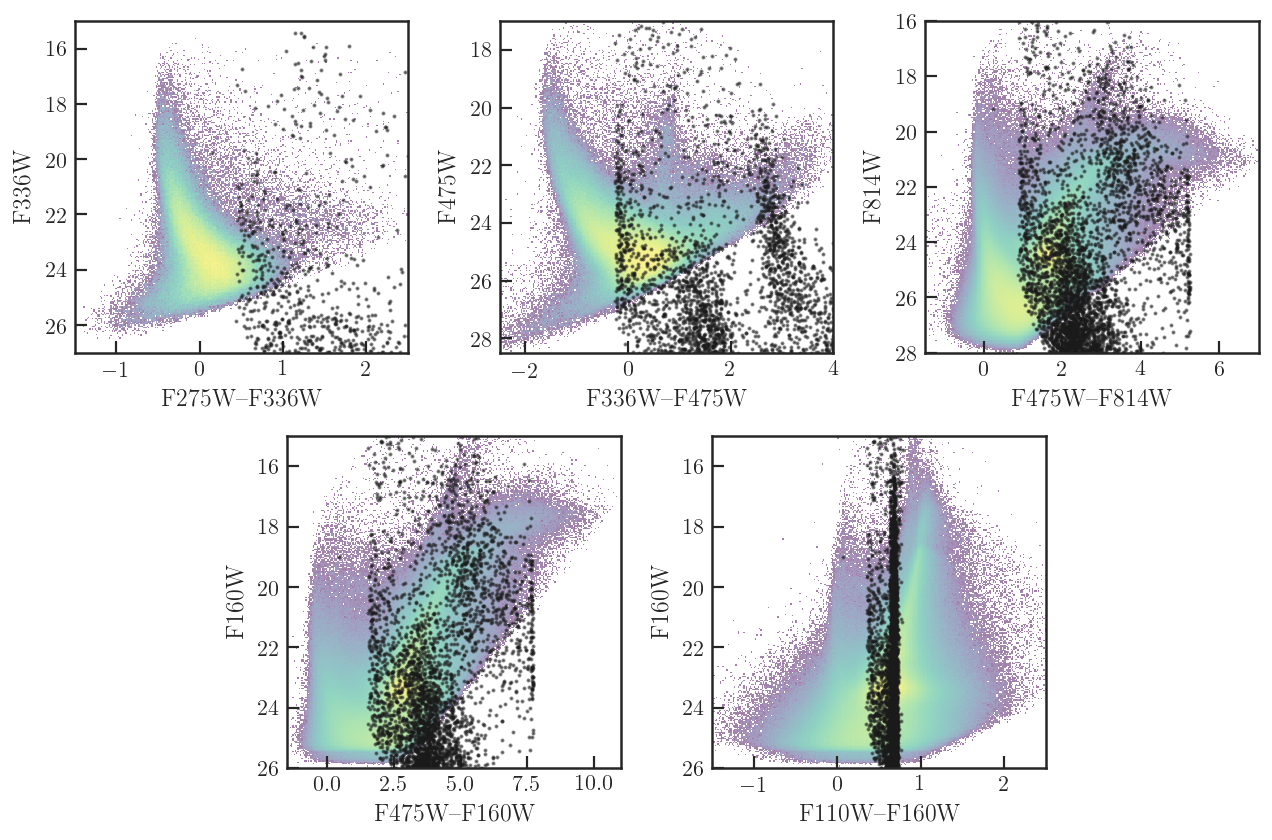

In [247]:
df = pd.read_csv('data/triout_m33_frg_260sqrarcmin.dat', delim_whitespace=True,
                 ).rename(columns=lambda x: x.replace('mag','').replace('W1','W'))

fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(4, 6)

plot_kwargs = dict(s=1, color='k', alpha=0.5)

def add_ax(gs0, gs1, f_blue, f_red, x0, x1, y0, y1, plot_kwargs=plot_kwargs):
    ax = fig.add_subplot(gs[gs0, gs1])
    plt.sca(ax)
    ax.scatter(df[f_blue]-df[f_red], df[f_red], **plot_kwargs)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ds.plot(f'{f_blue}_VEGA-{f_red}_VEGA', f'{f_red}_VEGA', f='log10', 
            colorbar=False, limits=[[x0, x1], [y0, y1]], colormap='viridis',
            selection=[f'{f_blue}_GST & {f_red}_GST', 'F110W_VEGA < 0'],
            xlabel='', ylabel='')
    ax.set_xlabel(f'{f_blue}--{f_red}')
    ax.set_ylabel(f_red)

add_ax(slice(0,2), slice(0,2), 'F275W', 'F336W', *[-1.5, 2.5], *[27, 15])
add_ax(slice(0,2), slice(2,4), 'F336W', 'F475W', *[-2.5, 4  ], *[28.5, 17])
add_ax(slice(0,2), slice(4,6), 'F475W', 'F814W', *[-1.5, 7  ], *[28, 16])
add_ax(slice(2,4), slice(1,3), 'F475W', 'F160W', *[-1.5, 11 ], *[26, 15])
add_ax(slice(2,4), slice(3,5), 'F110W', 'F160W', *[-1.5, 2.5], *[26, 15])

fig.tight_layout()
#fig.savefig('survey_paper_figures/trilegal_foreground.pdf', dpi=420, bbox_inches='tight')

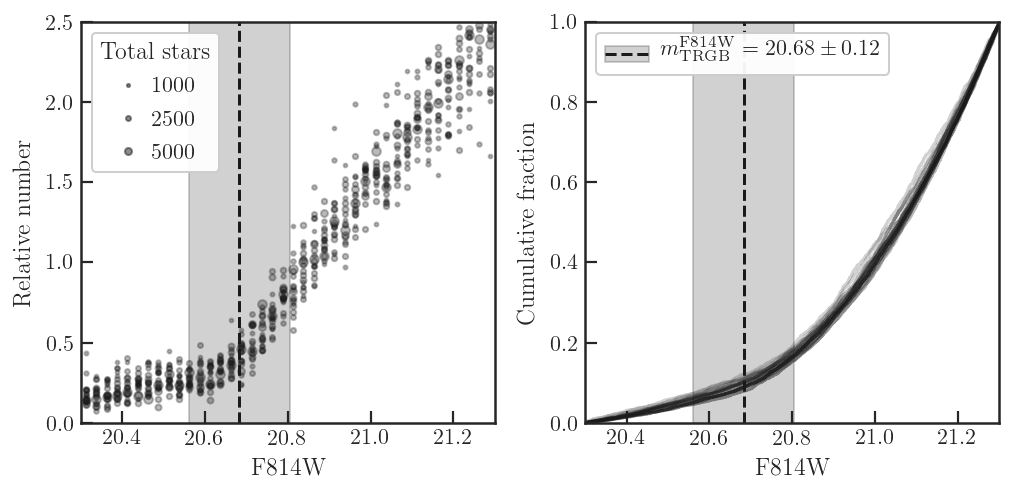

In [19]:
from matplotlib.legend_handler import HandlerTuple

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.6), sharex=True)

custom_lines = [Line2D([0], [0], marker='.', color='k', ms=1000**0.5/10, lw=0, label='1000', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=2500**0.5/10, lw=0, label='2500', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=5000**0.5/10, lw=0, label='5000', alpha=0.5)]
ax1.legend(handles=custom_lines, title='Total stars')

m, b = np.polyfit([1.5, 2.5], [22.5, 20.5], 1)
rgb_left = f'(F814W_VEGA > {m:.3f}*(F475W_VEGA-F814W_VEGA)+{b+0.25:.3f})'
rgb_right = f'(F814W_VEGA < {m:.3f}*(F475W_VEGA-F814W_VEGA)+{b+2.25:.3f})'
good_rgb = f'(F814W_ST & {rgb_left} & {rgb_right})'

good_fields = glob.glob('../m33_merged/M33_B0?_??.hdf5')
#good_fields += glob.glob('../m33_merged/M33_B01_[N,S][N,S].hdf5')

x0, x1 = 20.3, 21.3
s1 = f'((F814W_VEGA >= {x0}-0.001) & (F814W_VEGA <= {x1}+0.001))'
for p in good_fields:
    ds_ = open_and_select(p).dropna(column_names=['F814W_VEGA','F475W_VEGA'])
#     print(p.split('/')[-1].split('.')[0], 'X:', np.round(ds_.minmax('X')).astype(int),
#                                           'Y:', np.round(ds_.minmax('Y')).astype(int))
    f814w = ds_.evaluate('F814W_VEGA', selection=f'({good_rgb}) & {s1}')
    n_tot = len(f814w)
    n_, be = np.histogram(f814w, bins=np.arange(x0, x1+0.025, 0.025), 
                          range=(x0, x1), density=True)
    bc = (be[:-1] + be[1:])/2
    ax1.plot(bc, n_, 'k.', ms=n_tot**0.5/10, alpha=0.3)
    f814w = f814w[(f814w >= x0) & (f814w <= x1)]
    f814w.sort()
    n = np.cumsum(np.ones_like(f814w)) / n_tot
    ax2.plot(f814w, n, 'k', alpha=np.clip(n_tot/1e4, 0.2, 1))
    ds_.close_files()

Mtrgb = -4.05
dmod = 24.67
A814 = 0.063
err = (0.07**2 + 0.1**2)**0.5
mtrgb = Mtrgb+dmod+A814
ax1.axvline(mtrgb, color='k', linestyle='--')
ax1.fill_betweenx(ax1.get_ylim(), mtrgb-err, mtrgb+err, color='k', alpha=0.2)
line = ax2.axvline(mtrgb, color='k', linestyle='--')
ptch = ax2.fill_betweenx(ax2.get_ylim(), mtrgb-err, mtrgb+err, color='k', alpha=0.2)
ax2.legend(handles=[(ptch, line)],
           labels=['$m_{\mathrm{TRGB}}^{\mathrm{F814W}} =' + f'{mtrgb:.2f} \pm {err:.2f}$'],
           loc='upper left', handlelength=2, handler_map={tuple: HandlerTuple(ndivide=1)})
ax1.set_ylabel('Relative number')
ax2.set_ylabel('Cumulative fraction')
ax1.set_ylim(0, 2.5)
ax2.set_ylim(0, 1)
ax1.set_xlim(x0, x1)
ax1.set_xlabel('F814W')
ax2.set_xlabel('F814W')

fig.tight_layout(w_pad=1)
fig.savefig('survey_paper_figures/trgb_lfs.pdf', bbox_inches='tight')

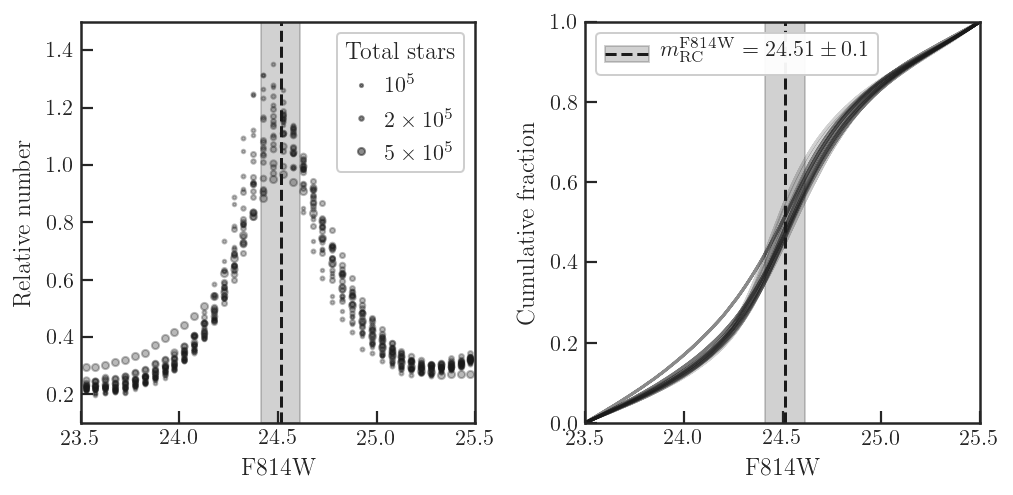

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.6), sharex=True)

custom_lines = [Line2D([0], [0], marker='.', color='k', ms=(1e5/1e4)**0.5, lw=0,
                       label='$10^5$', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=(2e5/1e4)**0.5, lw=0,
                       label=r'$2\times10^5$', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=(5e5/1e4)**0.5, lw=0,
                       label=r'$5\times10^5$', alpha=0.5)]
ax1.legend(handles=custom_lines, title='Total stars')

m, b = np.polyfit([1.5, 2.5], [24, 20], 1)
rc_left = f'(F814W_VEGA > {m:.3f}*(F475W_VEGA-F814W_VEGA)+{b-1:.3f})'
rc_right = f'(F814W_VEGA < {m:.3f}*(F475W_VEGA-F814W_VEGA)+{b+3:.3f})'
good_rc = f'((F814W_SHARP**2 < 0.2) & {rc_left} & {rc_right})'
ds.select(good_rc, name='good_rc')

x0, x1 = 23.5, 25.5
s1 = f'((F814W_VEGA >= {x0}-0.00001) & (F814W_VEGA <= {x1}+0.00001))'
for p in good_fields:
    ds_ = open_and_select(p).dropna(column_names=['F814W_VEGA','F475W_VEGA'])
#     print(p.split('/')[-1].split('.')[0], 'X:', np.round(ds_.minmax('X')).astype(int),
#                                           'Y:', np.round(ds_.minmax('Y')).astype(int))
    f814w = ds_.evaluate('F814W_VEGA', selection=f'({good_rc}) & {s1}')
    n_tot = len(f814w)
    n_, be = np.histogram(f814w, bins=np.arange(x0, x1+0.05, 0.05), 
                          range=(x0, x1), density=True)
    bc = (be[:-1] + be[1:])/2
    ax1.plot(bc, n_, 'k.', ms=(n_tot/1e4)**0.5, alpha=0.3)
    f814w = f814w[(f814w >= x0) & (f814w <= x1)]
    f814w.sort()
    n = np.cumsum(np.ones_like(f814w)) / n_tot
    ax2.plot(f814w, n, 'k', alpha=np.clip(n_tot/1e6, 0.2, 1))
    ds_.close_files()

Mrc = -0.22
dmod = 24.67
A814 = 0.063
rcerr = 0.1 #(0.07**2 + 0.03**2)**0.5
mrc = Mrc+dmod+A814
ax1.set_ylim(0.1, 1.5)
ax1.axvline(mrc, color='k', linestyle='--')
ax1.fill_betweenx(ax1.get_ylim(), mrc-rcerr, mrc+rcerr, color='k', alpha=0.2)
line = ax2.axvline(mrc, color='k', linestyle='--')
ptch = ax2.fill_betweenx(ax2.get_ylim(), mrc-rcerr, mrc+rcerr, color='k', alpha=0.2)
ax2.legend(handles=[(ptch, line)],
           labels=['$m_{\mathrm{RC}}^{\mathrm{F814W}} =' + f'{mrc:.2f} \pm {rcerr:.1f}$'],
           loc='upper left', handlelength=2, handler_map={tuple: HandlerTuple(ndivide=1)})
ax1.set_ylabel('Relative number')
ax2.set_ylabel('Cumulative fraction')
ax2.set_ylim(0, 1)
ax1.set_xlim(x0, x1)
ax1.set_xlabel('F814W')
ax2.set_xlabel('F814W')

fig.tight_layout(w_pad=1)
fig.savefig('survey_paper_figures/rc_lfs.pdf', bbox_inches='tight')

<string>:1: RuntimeWarning: invalid value encountered in greater
<string>:1: RuntimeWarning: invalid value encountered in less
/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


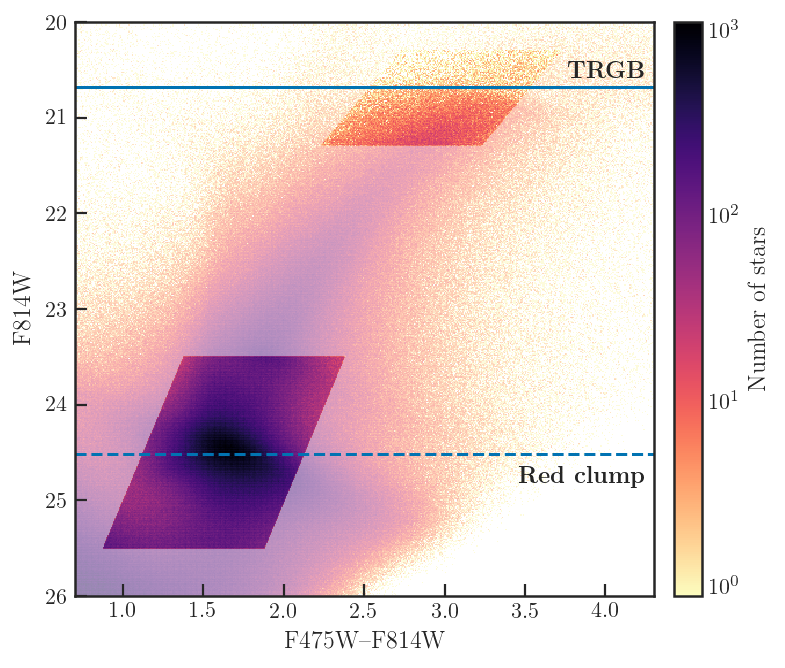

In [21]:
ds.select(good_rc, name='good_rc')
ds.select('(F814W_VEGA > 23.5) & (F814W_VEGA < 25.5)', mode='and', name='good_rc')
ds.select(good_rgb, name='good_rgb')
ds.select('(F814W_VEGA > 20.3) & (F814W_VEGA < 21.3)', mode='and', name='good_rgb')

ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=[[0.7, 4.3], [26, 20]],
        colormap='magma_r', f='log10', colorbar=False, #smooth_pre=0.1,
        vmin=np.log10(0.9), vmax=3.05, interpolation='None', shape=500, figsize=(4.8, 4.8), 
        xlabel='F475W--F814W', ylabel='F814W',
        selection=['OPT_GST', 'OPT_GST & (good_rc|good_rgb)'])
fig, ax = plt.gcf(), plt.gca()
ax.axhline(mtrgb, color=pal[0], linestyle='-')
ax.axhline(mrc, color=pal[0], linestyle='--')
ax.text(4.25, mtrgb-0.05, r'\textbf{TRGB}', ha='right', va='bottom')
ax.text(4.25, mrc+0.15, r'\textbf{Red clump}', ha='right', va='top')

add_colorbar(fig, ax, cmap='magma_r', vmin=0.9, vmax=10**3.05,
             norm='LogNorm', offset=0.03, width=0.04, label='Number of stars')
fig.tight_layout()
fig.savefig('survey_paper_figures/trgb_rc_cmd.pdf', dpi=420, bbox_inches='tight')

/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


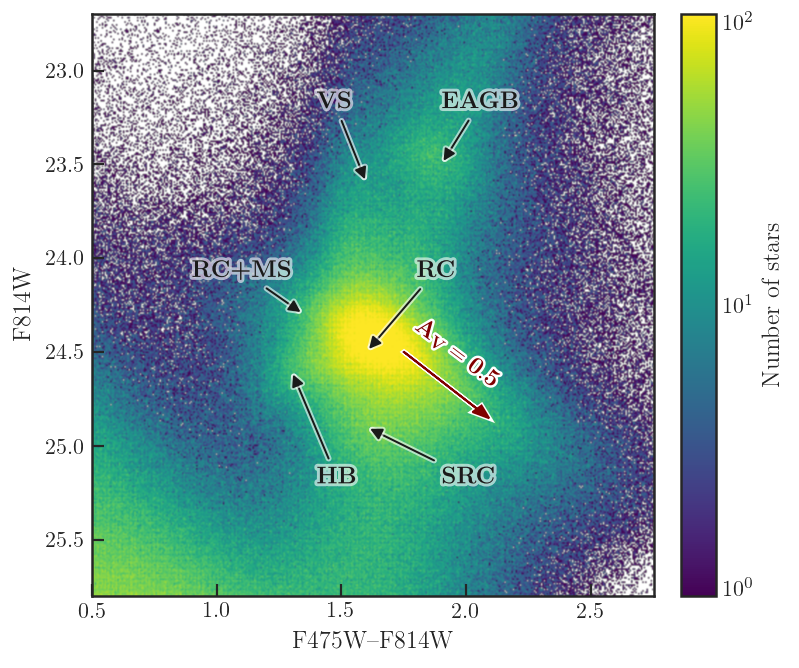

In [243]:
import matplotlib.patheffects as path_effects

ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', f='log10', selection='OPT_GST & (DENSITY < 0.15)',
        limits=[[0.5, 2.75], [25.8, 22.7]], colormap='viridis', shape=400,
        interpolation='bicubic', vmin=np.log10(0.95), vmax=2.03, colorbar=False, 
        figsize=(4.8, 4.8), xlabel='F475W--F814W', ylabel='F814W')
fig, ax = plt.gcf(), plt.gca()

stroke = path_effects.withStroke(linewidth=3, foreground='w', alpha=0.6)
# shadow = path_effects.withSimplePatchShadow(offset=(1, -1), shadow_rgbFace='w', alpha=1)
arrowprops = dict(arrowstyle='-|>', color='k', path_effects=[stroke])
annot_kwargs = dict(color='k', size=12, arrowprops=arrowprops,
                    path_effects=[stroke])

ax.arrow(1.75, 24.5, 0.5*(1.19119-0.60593), 0.5*0.60593, head_width=0.05,
         head_length=0.07, fc='maroon', ec='maroon', zorder=3, path_effects=[pa])
ax.text(1.77, 24.71, r'$\bf{A_V=0.5}$', zorder=2, rotation=-37, color='maroon', size=12, path_effects=[pa])
ax.annotate(r'\textbf{RC}', xy=(1.6, 24.5), xytext=(1.8, 24.1), **annot_kwargs)
ax.annotate(r'\textbf{SRC}', xy=(1.6, 24.9), xytext=(1.9, 25.2), **annot_kwargs)
ax.annotate(r'\textbf{EAGB}', xy=(1.9, 23.5), xytext=(1.9, 23.2), **annot_kwargs)
ax.annotate(r'\textbf{HB}', xy=(1.3, 24.6), xytext=(1.4, 25.2), **annot_kwargs)
ax.annotate(r'\textbf{VS}', xy=(1.6, 23.6), xytext=(1.4, 23.2), **annot_kwargs)
ax.annotate(r'\textbf{RC+MS}', xy=(1.35, 24.3), xytext=(0.9, 24.1), **annot_kwargs)


cb = add_colorbar(fig, ax, cmap='viridis', vmin=0.95, vmax=10**2.03,
                  norm='LogNorm', #norm_args={'gamma':0.3},
                  offset=0.04, width=0.05, label='Number of stars')
# cb.set_ticks([0, 1, 10, 25, 50, 100, 200, 300])
fig.tight_layout()
fig.savefig('survey_paper_figures/zoomed_cmd.pdf', dpi=420, bbox_inches='tight')

/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


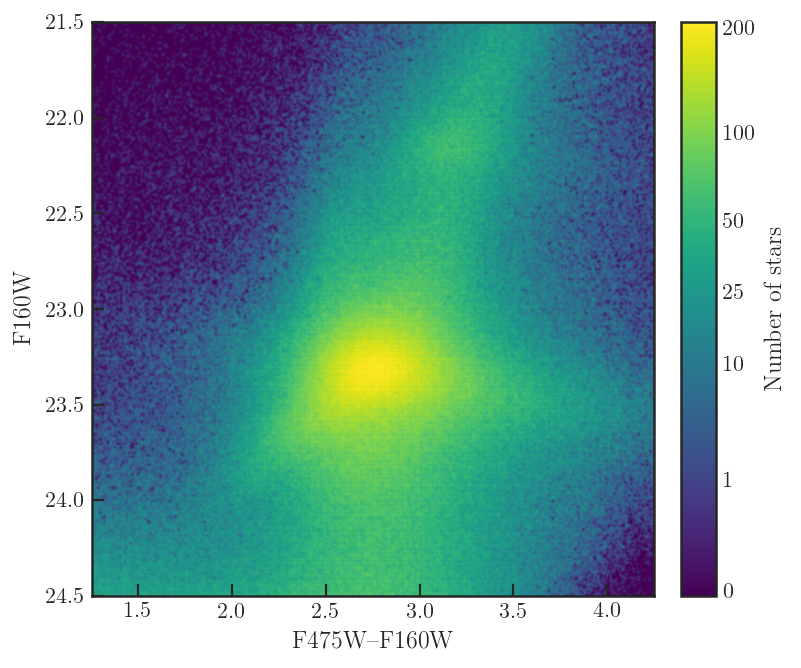

In [187]:
ds.plot('F475W_VEGA-F160W_VEGA', 'F160W_VEGA', f='arcsinh',
        selection='F475W_GST & F160W_GST & (DENSITY < 0.15)',
        limits=[[1.25, 4.25], [24.5, 21.5]], colormap='viridis', shape=300,
        interpolation='bicubic', vmin=-5e-5, vmax=6.02, colorbar=False, 
        figsize=(4.8, 4.8), xlabel='F475W--F160W', ylabel='F160W')
fig, ax = plt.gcf(), plt.gca()
cb = add_colorbar(fig, ax, cmap='viridis', vmin=-5e-5, vmax=np.sinh(6.02),
                  norm='PowerNorm', norm_args={'gamma':0.3},
                  offset=0.04, width=0.05, label='Number of stars')
cb.set_ticks([0, 1, 10, 25, 50, 100, 200, 300])
fig.tight_layout()

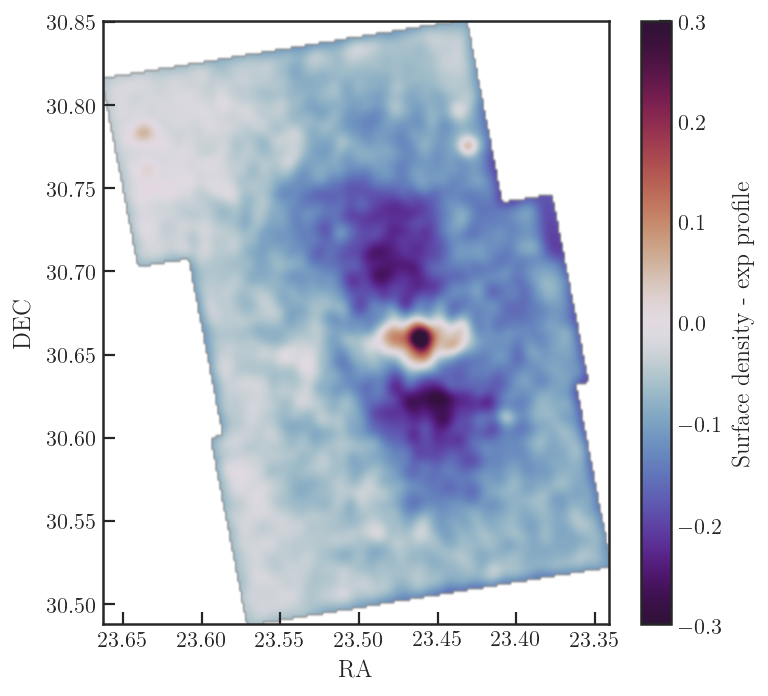

In [22]:
from m33_utils import deg_to_deproj

distA, distB = deg_to_deproj(ds.RA, ds.DEC)
ds['distA'] = distA
ds['distB'] = distB

ds['dist'] = (ds.distA**2 + ds.distB**2)**0.5
# old star scale length 0.5-3.5kpc: 1.51 kpc, verley 09
ds['sersic'] = np.exp(-ds.dist/1.51)

ds.plot('RA', 'DEC', what='mean(DENSITY-sersic)', figsize=(5.5, 5),
        colormap='twilight_shifted', limits='minmax', vmin=-0.3, vmax=0.3,
        colorbar_label='Surface density - exp profile', interpolation='bicubic')
plt.gca().invert_xaxis()